In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns
import glob

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

In [ ]:
image_dir = Path('/content/drive/MyDrive/Arefin/Covid19-Pneumonia-Normal Chest X-Ray Images Dataset')
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,/content/drive/MyDrive/Arefin/Covid19-Pneumoni...,COVID
1,/content/drive/MyDrive/Arefin/Covid19-Pneumoni...,COVID
2,/content/drive/MyDrive/Arefin/Covid19-Pneumoni...,COVID


Visualization

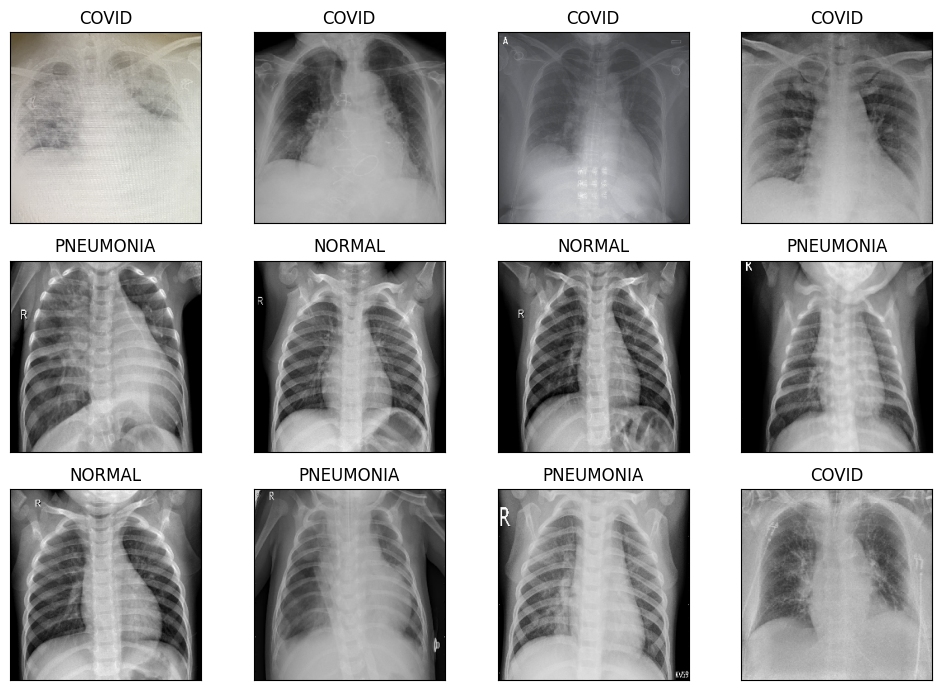

In [ ]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
vc = image_df['Label'].value_counts()
print(vc)

NORMAL       1802
PNEUMONIA    1800
COVID        1626
Name: Label, dtype: int64


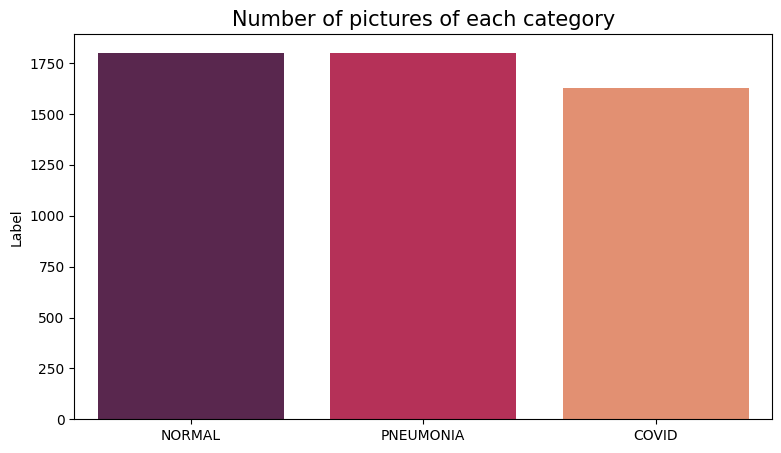

In [ ]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)

    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

Found 4705 validated image filenames belonging to 3 classes.
Found 4705 validated image filenames belonging to 3 classes.
Found 523 validated image filenames belonging to 3 classes.






DenseNet201 Model Training Started ===>>>
Epoch 1/20
148/148 [==============================] - 1738s 12s/step - loss: 0.1774 - accuracy: 0.9354 - val_loss: 0.1148 - val_accuracy: 0.9513
Epoch 2/20
148/148 [==============================] - 44s 298ms/step - loss: 0.0997 - accuracy: 0.9649 - val_loss: 0.0561 - val_accuracy: 0.9811
Epoch 3/20
148/148 [==============================] - 45s 303ms/step - loss: 0.0721 - accuracy: 0.9751 - val_loss: 0.1016 - val_accuracy: 0.9600
Epoch 4/20
148/148 [==============================] - 45s 301ms/step - loss: 0.0645 - accuracy: 0.9781 - val_loss: 0.0353 - val_accuracy: 0.9879
Epoch 5/20
148/148 [==============================] - 64s 434ms/step - loss: 0.0428 - accuracy: 0.9860 - val_loss: 0.0347 - val_accuracy: 0.9904
Epoch 6/20
148/148 [=========================

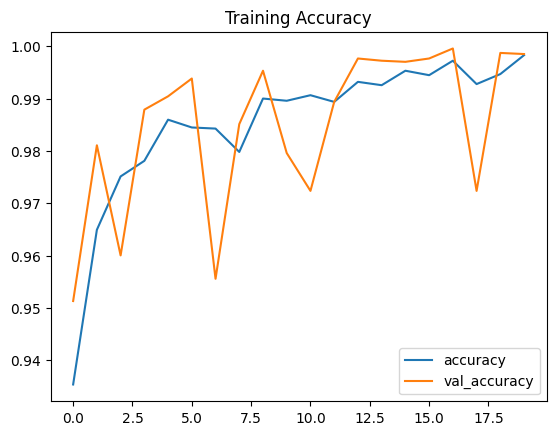

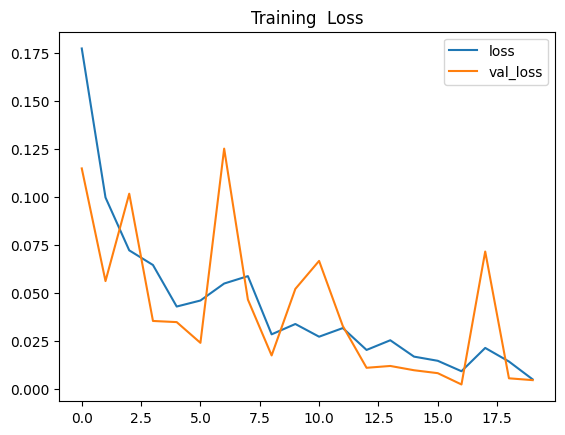



Accuracy on the test set: 97.51%
17/17 [==============================] - 6s 171ms/step
Accuracy: 0.97514
Precision: 0.97549
Recall: 0.97514
F1 Score: 0.97517
              precision    recall  f1-score   support

       COVID       1.00      0.99      0.99       170
      NORMAL       0.98      0.95      0.96       165
   PNEUMONIA       0.95      0.98      0.97       188

    accuracy                           0.98       523
   macro avg       0.98      0.97      0.98       523
weighted avg       0.98      0.98      0.98       523

DenseNet201 Confusion Matrix: 




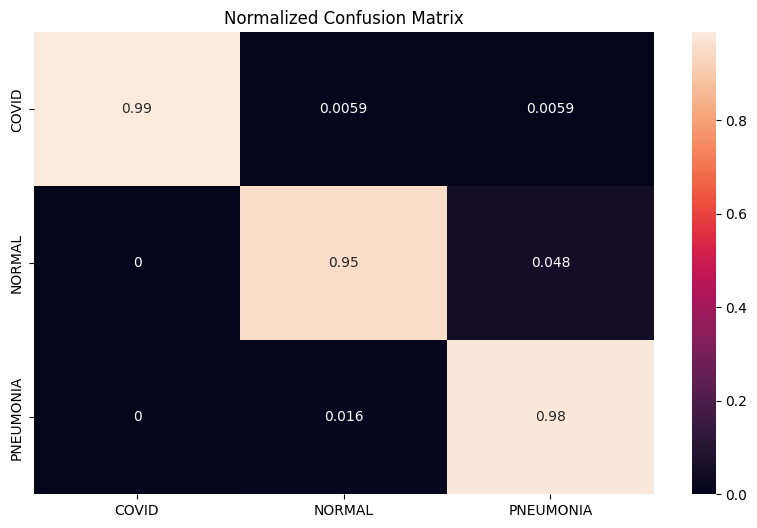

Performance: 

Rec=    97.45976662747626
Spe=    99.99513365254306
Pre=    97.50687119176537
FPR=    0.004866347456942024
FNR=    2.540233372523733
NPV=    99.9951337525188
FDR=    2.493128808234635




51877672/51877672 [==============================] - 3s 0us/step
DenseNet169 Model Training Started ===>>>
Epoch 1/20
148/148 [==============================] - 52s 283ms/step - loss: 0.1984 - accuracy: 0.9275 - val_loss: 0.0982 - val_accuracy: 0.9705
Epoch 2/20
148/148 [==============================] - 38s 258ms/step - loss: 0.1396 - accuracy: 0.9522 - val_loss: 0.0792 - val_accuracy: 0.9741
Epoch 3/20
148/148 [==============================] - 40s 269ms/step - loss: 0.0922 - accuracy: 0.9660 - val_loss: 0.0694 - val_accuracy: 0.9764
Epoch 4/20
148/148 [==============================] - 40s 272ms/step - loss: 0.0706 - accuracy: 0.9773 - val_loss: 0.1130 - val_accuracy: 0.9581
Epoch 5/20
148/148 [==============================] - 40s 272ms/step - loss: 0.0613 - accuracy: 0.9785 - val_l

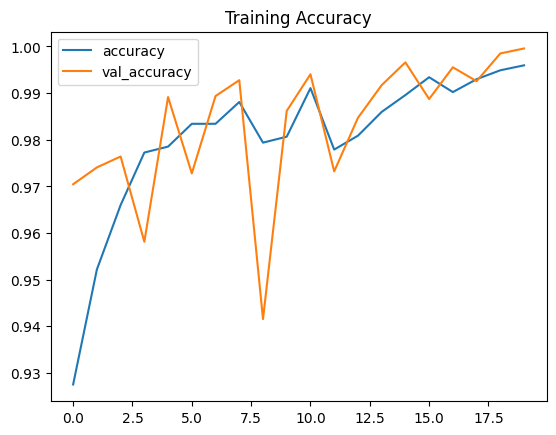

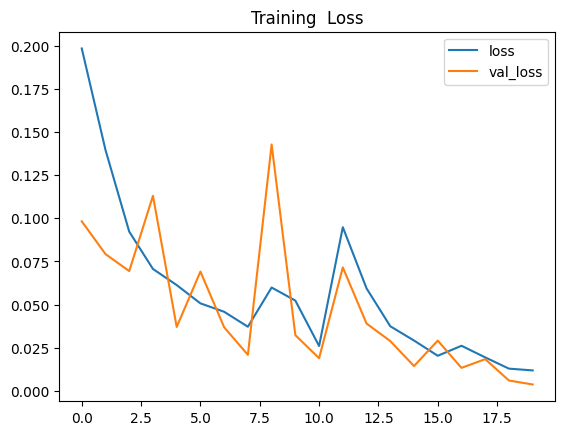



Accuracy on the test set: 97.51%
17/17 [==============================] - 5s 125ms/step
Accuracy: 0.97514
Precision: 0.97514
Recall: 0.97514
F1 Score: 0.97514
              precision    recall  f1-score   support

       COVID       0.99      0.99      0.99       170
      NORMAL       0.96      0.96      0.96       165
   PNEUMONIA       0.97      0.97      0.97       188

    accuracy                           0.98       523
   macro avg       0.98      0.98      0.98       523
weighted avg       0.98      0.98      0.98       523

DenseNet169 Confusion Matrix: 




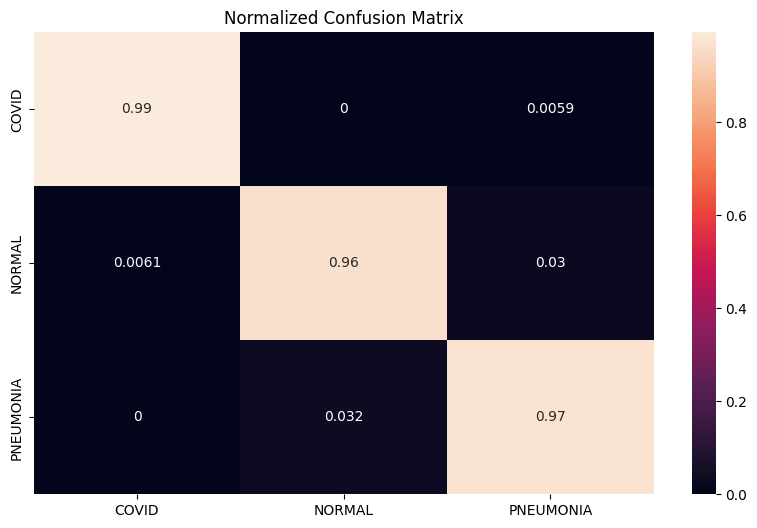

Performance: 

Rec=    97.5279705692722
Spe=    99.99526431143538
Pre=    97.52838179300335
FPR=    0.004735688564612649
FNR=    2.472029430727803
NPV=    99.99526431442386
FDR=    2.4716182069966437




87910968/87910968 [==============================] - 5s 0us/step
InceptionV3 Model Training Started ===>>>
Epoch 1/20
148/148 [==============================] - 46s 258ms/step - loss: 0.3832 - accuracy: 0.8504 - val_loss: 0.2208 - val_accuracy: 0.9273
Epoch 2/20
148/148 [==============================] - 35s 237ms/step - loss: 0.1958 - accuracy: 0.9284 - val_loss: 0.1550 - val_accuracy: 0.9477
Epoch 3/20
148/148 [==============================] - 36s 247ms/step - loss: 0.1492 - accuracy: 0.9479 - val_loss: 0.1410 - val_accuracy: 0.9494
Epoch 4/20
148/148 [==============================] - 39s 261ms/step - loss: 0.1553 - accuracy: 0.9441 - val_loss: 0.0986 - val_accuracy: 0.9696
Epoch 5/20
148/148 [==============================] - 35s 236ms/step - loss: 0.1376 - accuracy: 0.9503 - val_

In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Dictionary with the models

models = {
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet50, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')
print('\n')

# Fit the models
for name, model in models.items():
    print('\n')

    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m


    print(f"{name:2} Model Training Started ===>>>")


    start = perf_counter()

    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=20,verbose=1)

    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:2} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

    results = m.evaluate(test_images, verbose=0)
    res=results[1]
    models[name]['test_accuracy'] = [round(res,4)]

    #ploting training acc loss
    print(f"{name:2} Train Accuracy and Loss Plot: \n")

    pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
    plt.title("Training Accuracy")
    plt.show()
    pd.DataFrame(history.history)[['loss','val_loss']].plot()
    plt.title("Training  Loss")
    plt.show()

    print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))


    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    pred = m.predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    y_test = list(test_df.Label)

    print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
    print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
    print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
    print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
    print(classification_report(y_test, pred))


    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    import math
    from numpy import mean


    print(f"{name:2} Confusion Matrix: \n\n")
    cf_matrix = confusion_matrix(y_test, pred, normalize='true')
    plt.figure(figsize = (10,6))
    sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
    plt.title('Normalized Confusion Matrix')
    plt.show()

    confusion_matrix=cf_matrix

    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = len(y_test) - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    print("Performance: \n")
    print("Rec=   ",mean(TPR)*100)
    print("Spe=   ",mean(TNR)*100)
    print("Pre=   ",mean(PPV)*100)
    print("FPR=   ",mean(FPR)*100)
    print("FNR=   ",mean(FNR)*100)
    print("NPV=   ",mean(NPV)*100)
    print("FDR=   ",mean(FDR)*100)
    print("\n")

In [ ]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name,
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Dictionary with the models
models = {
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')
print('\n')

# Fit the models
for name, model in models.items():
    print('\n')

    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m


    print(f"{name:2} Model Training Started ===>>>")


    start = perf_counter()

    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=30,verbose=1)

    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:2} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

    results = m.evaluate(test_images, verbose=0)
    res=results[1]
    models[name]['test_accuracy'] = [round(res,4)]

    #ploting training acc loss
    print(f"{name:2} Train Accuracy and Loss Plot: \n")

    pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
    plt.title("Training Accuracy")
    plt.show()
    pd.DataFrame(history.history)[['loss','val_loss']].plot()
    plt.title("Training  Loss")
    plt.show()

    print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))


    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    pred = m.predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    y_test = list(test_df.Label)

    print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
    print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
    print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
    print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
    print(classification_report(y_test, pred))


    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    import math
    from numpy import mean


    print(f"{name:2} Confusion Matrix: \n\n")
    cf_matrix = confusion_matrix(y_test, pred, normalize='true')
    plt.figure(figsize = (10,6))
    sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
    plt.title('Normalized Confusion Matrix')
    plt.show()

    confusion_matrix=cf_matrix

    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = len(y_test) - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    print("Performance: \n")
    print("Rec=   ",mean(TPR)*100)
    print("Spe=   ",mean(TNR)*100)
    print("Pre=   ",mean(PPV)*100)
    print("FPR=   ",mean(FPR)*100)
    print("FNR=   ",mean(FNR)*100)
    print("NPV=   ",mean(NPV)*100)
    print("FDR=   ",mean(FDR)*100)
    print("\n")